<a href="https://colab.research.google.com/github/mjahidulalam/TwitterClassification/blob/master/Twitter_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
df = pd.read_json("/content/drive/My Drive/Colab Notebooks/Twitter Classification/random_tweets.json", lines=True)
display(df.head())

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 145388018, 'id_str': '145388018', 'name...",None,None,None,NaN,{'created_at': 'Mon Jul 30 16:49:41 +0000 2018...,False,3,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,9.271857e+17,9.271857e+17,hail_ee23,"{'id': 2407992339, 'id_str': '2407992339', 'na...",None,None,"{'id': '26b41b13d49ea2bf', 'url': 'https://api...",NaN,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 901579698223931392, 'id_str': '90157969...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:03:32 +0000 2018...,False,5,0,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN
3,2018-07-31 13:34:40+00:00,1024287229496029190,1024287229496029184,RT @realDonaldTrump: One of the reasons we nee...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 23438548, 'id_str': '23438548', 'name':...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:00:41 +0000 2018...,False,11106,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-31 13:34:40+00:00,1024287229492031490,1024287229492031488,RT @First5App: This hearing of His Word doesn’...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 942424782, 'id_str': '942424782', 'name...",None,None,None,NaN,{'created_at': 'Tue Jul 31 12:30:05 +0000 2018...,False,6,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
df.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')

In [165]:
df['user'][0]

{'contributors_enabled': False,
 'created_at': 'Tue May 18 21:30:10 +0000 2010',
 'default_profile': False,
 'default_profile_image': False,
 'description': '',
 'entities': {'description': {'urls': []}},
 'favourites_count': 3419,
 'follow_request_sent': False,
 'followers_count': 215,
 'following': False,
 'friends_count': 335,
 'geo_enabled': True,
 'has_extended_profile': True,
 'id': 145388018,
 'id_str': '145388018',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': 'en',
 'listed_count': 2,
 'location': 'Waterloo, Iowa',
 'name': 'Derek Wolkenhauer',
 'notifications': False,
 'profile_background_color': '022330',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme15/bg.png',
 'profile_background_tile': False,
 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/145388018/1494937921',
 'profile_image_url': 'http://pbs.twimg.com/profile_ima

In [166]:
median_retweets = df['retweet_count'].median()
df['is_viral'] = np.where(df['retweet_count'] > median_retweets, 1,0)
df['followers_count'] = df.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
df['friends_count'] = df.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
df['is_verified'] = df.apply(lambda tweet: np.where(tweet['user']['verified'] == True, 1,0), axis=1)
df['hashtag_count'] = df.apply(lambda tweet: tweet['text'].count('#'), axis=1)
df['tweet_length'] = df.apply(lambda tweet: len(tweet['text'].split()), axis=1)

ohe = OneHotEncoder()
tranformed_lang = ohe.fit_transform(df[['lang']]).toarray()
tranformed_lang_df = pd.DataFrame(tranformed_lang, columns = ohe.categories_)
df = pd.concat([df,tranformed_lang_df], axis =1)

df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries,is_viral,followers_count,friends_count,is_verified,hashtag_count,tweet_length,"(ar,)","(ca,)","(de,)","(el,)","(en,)","(es,)","(et,)","(fa,)","(fi,)","(fr,)","(hi,)","(ht,)","(in,)","(it,)","(ja,)","(ko,)","(nl,)","(pl,)","(pt,)","(ro,)","(ru,)","(sl,)","(sv,)","(th,)","(tl,)","(tr,)","(und,)","(ur,)","(vi,)","(zh,)"
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 145388018, 'id_str': '145388018', 'name...",None,None,None,NaN,{'created_at': 'Mon Jul 30 16:49:41 +0000 2018...,False,3,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,0,215,335,0,0,26,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,9.271857e+17,9.271857e+17,hail_ee23,"{'id': 2407992339, 'id_str': '2407992339', 'na...",None,None,"{'id': '26b41b13d49ea2bf', 'url': 'https://api...",NaN,NaN,False,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,0,199,203,0,0,15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 901579698223931392, 'id_str': '90157969...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:03:32 +0000 2018...,False,5,0,False,False,en,0.0,NaN,NaN,NaN,NaN,NaN,0,196,558,0,0,22,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-07-31 13:34:40+00:00,1024287229496029190,1024287229496029184,RT @realDonaldTrump: One of the reasons we nee...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 23438548, 'id_str': '23438548', 'name':...",None,None,None,NaN,{'created_at': 'Tue Jul 31 11:00:41 +0000 2018...,False,11106,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,1,3313,2272,0,0,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-07-31 13:34:40+00:00,1024287229492031490,1024287229492031488,RT @First5App: This hearing of His Word doesn’...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 942424782, 'id_str': '942424782', 'name...",None,None,None,NaN,{'created_at': 'Tue Jul 31 12:30:05 +0000 2018...,False,6,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,0,125,273,0,0,24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
train_columns = ['favorite_count','followers_count','friends_count', 'is_verified','hashtag_count','tweet_length']
df.iloc[:,-30:].columns.shape
train_columns += df.iloc[:,-30:].columns.tolist()
len(train_columns)

36

In [187]:
labels = df["is_viral"]
data = df[train_columns]

scaled_data = scale(data, axis = 0)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 1)
train_data = train_data.to_numpy().astype(float)
test_data = test_data.to_numpy().astype(float)
train_labels = train_labels.to_numpy().astype(float)
test_labels = test_labels.to_numpy().astype(float)

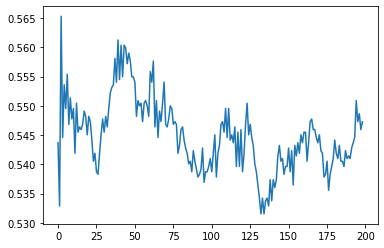

In [195]:
scores = []

for k in range(1,200):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))

plt.plot(scores)
plt.show()

In [188]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1,36)),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss ='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [193]:
model.fit(train_data, train_labels, epochs=20)

Epoch 1/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6628 - accuracy: 0.5840
Epoch 2/20
278/278 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.5756
Epoch 3/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6592 - accuracy: 0.5842
Epoch 4/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6597 - accuracy: 0.5898
Epoch 5/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6624 - accuracy: 0.5877
Epoch 6/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6661 - accuracy: 0.5826
Epoch 7/20
278/278 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5836
Epoch 8/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6635 - accuracy: 0.5849
Epoch 9/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6624 - accuracy: 0.5822
Epoch 10/20
278/278 [==============================] - 0s 1ms/step - loss: 0.6601 - accuracy: 0.5909

In [194]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose = 1)

70/70 [==============================] - 0s 1ms/step - loss: 0.6686 - accuracy: 0.5811
